# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# TODO: Total number of records
n_records = len(data.index)

# TODO: Number of records where individual's income is more than $50,000

l=data[data['income'] == ">50K"].index
n_greater_50k = len(l)

# TODO: Number of records where individual's income is at most $50,000
l=data[data['income'] == "<=50K"].index
n_at_most_50k = len(l)

# TODO: Percentage of individuals whose income is more than $50,000
p=float(n_greater_50k)/n_records*100.0
greater_percent =p

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

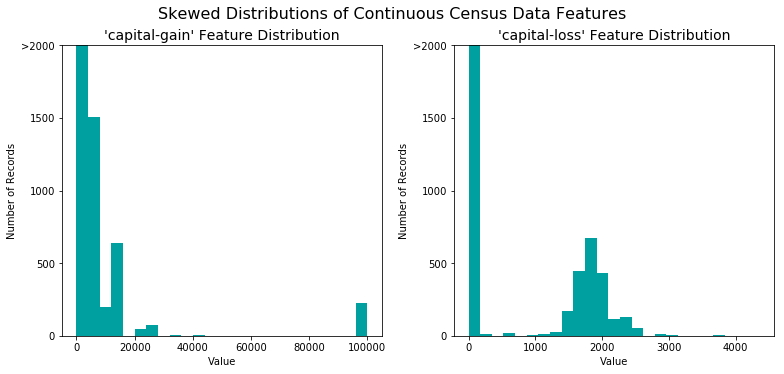

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

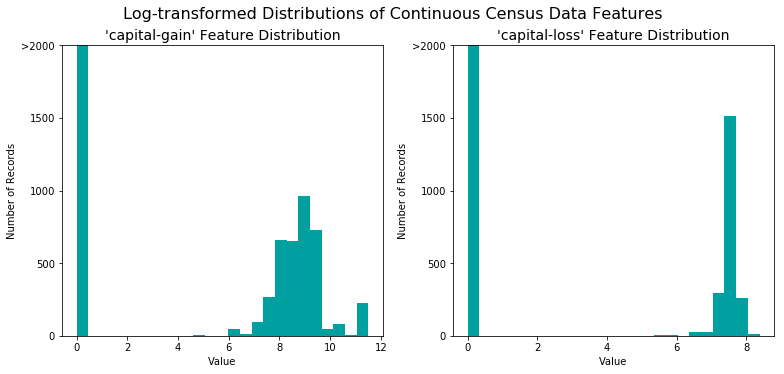

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# TODO: Encode the 'income_raw' data to numerical values
d={"<=50K": 0, ">50K": 1}
income = income_raw.map(d)
#Checking output
display(income_raw.head(10),income.head(10))

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
print encoded

0    <=50K
1    <=50K
2    <=50K
3    <=50K
4    <=50K
5    <=50K
6    <=50K
7     >50K
8     >50K
9     >50K
Name: income, dtype: object

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    1
8    1
9    1
Name: income, dtype: int64

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [7]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [10]:
# Calculate accuracy by hand
prediction = np.asarray([1]*n_records)

#TP-True Positives TN=True Negatives FP=False Positives FN=False Negatives
TP = income[(income == 1) & (prediction == 1)].count()
TN = income[(income == 0) & (prediction == 0)].count()
FP = income[(income == 0) & (prediction == 1)].count()
FN = income[(income == 1) & (prediction == 0)].count()

accuracy = float(TP+TN)/n_records

# Calculate F-score using the formula above for beta = 0.5
beta = 0.5
precision = float(TP)/(TP+FP)
recall = float(TP)/(TP+FN)
#Using Formula given above to calculate the f-beta sore
fscore = (1+beta**2) * (precision*recall)/((precision*beta**2)+recall)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

# Check against sklearn calcs
from sklearn.metrics import accuracy_score, fbeta_score
print ( "SKLearn Accuracy: ", accuracy_score(income, prediction), "SKLearn F-score", fbeta_score(income, prediction, beta) )

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]
('SKLearn Accuracy: ', 0.24784396974923709, 'SKLearn F-score', 0.29172913543228385)


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: **  ***End Notes have been used for referencing denoted by [n] in the text below.**

I am choosing three supervised learning models based on Nature of data and the Outcome of the solution[1][2].

(1)Naive Bayes

(2)Decision Trees

(3)Logistic Regression (Based on suggestion from review)

**Real world application** of the three models are as follows:

**Logistic Regression:** Logistic Regression is used for a variety of applications in the real world but I would like to highlight one unique one for NASA space flight crash investigations for Shuttle Challenger to find out the relationship of O-ring damage to temperature which was a primary argument to find out if temperature was the cuase of such accidents and enablish the NASA engineers to make a decision of a flight launch should happen or not given temperature[5].

**Gaussain Naive Bayes:** Naive Bayes is being used by NASA Goddard Space Flight Center for classifying to content based data management[6]. NASA uses it for TBs worth of images to classify based on ocean color free of cloud and sun-glint for its users as an example.

**Decision Trees:** Decision Trees are used in banking industry and in particularly for option pricing for predicting price of an option in either a bull or bear market{3]. It is also used in Drug development and testing[4] for Predicting the Probability of Success in Phase 3 of drug development and testing[4].

**Strengths:**
I have put the Strengths of the three models based on the Machine Learning algorithm matrix[2] and other sources referenced, which considers Preference bias of each model to tell its strength and applicability :

**Linear Regression:** The Strengths of Linear regression model are outlined below:
•	No linear relationship between the Independant Variable and Dependant Variable has to be assumed.
•	Can handle nonlinear effect as well.
•	Independant Variable can be categorical variable and bounded.

**Gaussain Naive Bayes:** It prefers[2] problems where the probability will always be >0 for each class[2]. Rare events are hard to predict with this algorithm.
•	Naive Bayes performs well when inputs are independent from one another.
•	Good at separating signal from noise in the dataset.
•	Naïve Bayes has a fast training speed and quick prediction ability.
•	The algorithm has ability to handle many features.
•	The algorithm takes very few parameters so it's hard to overfit.

**Decision Trees:** This algorithm prefers problems that are decision based.
•	Performs well with smaller decision trees than bigger ones.
•	Easy to understand and explain due to clear visualization.
•	Decision trees perform well on Boolean functions.
•	It has a Fast training speed and prediction.

**Weaknesses:**  
I have put the Weaknesses of the three models based on the Machine Learning algorithm matrix[2] and other sources referenced, which considers Restriction bias of each model to tell its weakness and applicability. 

**Linear Regression:** Biggest restriction is that it works with data only where there is a definite distinction between two   classifications[2].
•	Logistic regression attempts to predict outcomes based on identified set of independent variables, but if wrong independent variables are identified then the model will give wrong predictive values.
•	Logit models may show more predictive ability than they actually do as a result of sampling bias when some members of the intended population are less likely to be included than other.
•	Slow in training phase. Fast in test phase.

**Gaussain Naive Bayes:** Restriction bias on this algorithm is that it works on problems where inputs are independent of each other. If they are not independent and there is any dependency between them then this algorithm fails.
•   If dataset is small it produces high bias in the model.
•   Being simple to compute and predict it can give rise to bad generalizations.	
•   Since it assumes independence in features it does not take care of interactions between the features.	

**Decision Trees:** Decision trees have a restriction bias on attributes with large number of values[8] can lead to selection of values that are sub-optimal to model's performance.
•   Generalize poorly in comparison to other algorithms.	
•	Decision tree algorithm consume high memory for computation.
•	Prone to overfitting.
•	Performance decreases with growth of decision tree.

**Good candidate:**
**Logistic Regression:** It is the best model to use because it has a preference bias for binary classification which is very much present in our data.

**Naive Bayes:** This algorithm has a preference for problems for binary classification in our case we have classified income as d={"<=50K": 0, ">50K": 1} less than 50K and more than 50K. In our dataset the number of people who have income levels greater than 50K are 24.78% which is not a rare event and hence Naive Bayes can be used easily to predict. Accuracy will have to be compared with Logistic Regression and Decision Trees.

**Decision Trees:** This algorithm prefers problems which require to take decisions based on classification. Our classification is based on income of less than 50K and more than 50K. So a decision tree can help us arrive at the decision of which people are predicted to have an income of 50K and should be sent the mailers.


**References:**
 
[1]How to choose algorithms for Microsoft Azure Machine Learning, https://docs.microsoft.com/en-us/azure/machine-learning/machine-learning-algorithm-choice

[2]Page 206, Chapter 11, Thoughtful Machine Learning by Matthew Kirk,O'REILLY (SPD India),2014 

[3]Page 46, Chapter 3, Machine Learning for Big Data, Jason Bell, O'REILLEY, Reprint 2016

[4]Tony Sabin, James Matcham, Sarah Bray, Andrew Copas, and Mahesh K. B. Parmar, A Quantitative Process for Enhancing End of Phase 2 Decisions. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3967501/

[5]Siddhartha, Edward, Bruce, Risk Analysis of the Space Shuttle: Prechallenger Prediction of Failure, http://www.ics.uci.edu/~staceyah/111-202/handouts/Dalal_etal_1989-Challenger.pdf, Journal of the American Statistical Association, Vol. 84, No. 408 (Dec., 1989), pp. 945-957

[6]Application of Bayesian Classification to Content-based Data
Management, NASA, C. Lynnes, S. Berrick, A. Gopalan, X. Hua, S. Shen, P. Smith, K-Y. Yang, https://esto.nasa.gov/conferences/estc2004/papers/b8p4.pdf 

[7][1]K. Markham, "Comparing supervised learning algorithms", Data School, 2015.: http://www.dataschool.io/comparing-supervised-learning-algorithms/

[8]Machine Learning for Language Technology 2015, Marina Santini, https://www.slideshare.net/marinasantini1/lecture-4-decision-trees-2-entropy-information-gain-gain-ratio-55241087 

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [11]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner.fit(X_train.head(sample_size), y_train.head(sample_size))
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] =  end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    beta=0.5
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.


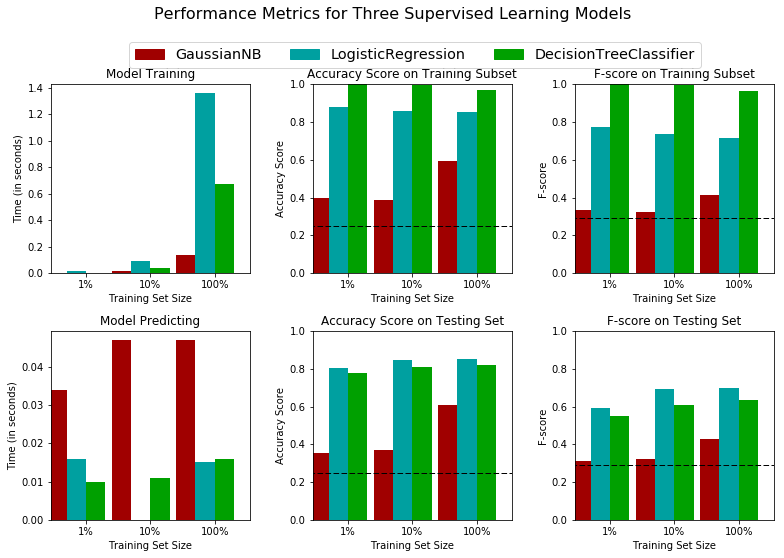

In [12]:
# Import the three supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Initialize the three models
clf_A = GaussianNB()
clf_B = DecisionTreeClassifier(criterion="entropy",random_state=0)
clf_C = LogisticRegression(C=1e5,random_state=0,multi_class='ovr',n_jobs=-1)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
#Defining function since percent is required 3 times
def getsample(percent):
    return int((float(percent)/100)*X_train.shape[0])

samples_1 = getsample(1.0)
samples_10 = getsample(10.0)
samples_100 = getsample(100.0)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer: **

In earlier discussion on model selection I had mentioned that Logistic Regression is the best model for predicting binary classification based on our current problem. Let us look closely at the metrics in the graphs above to see if this expectation was matched correctly.

Model Training: Highest Model training time is for Logistic Regression then Decision Trees and last Naive Bayes for 10% and 100% samples. However during testing we see a different result. Naive Bayes takes a longer duration to test than all other algorithms for all percent of samples. However for 10% test samples only Naive Bayes and Decision Tree take time and Logistic Regression does not take any time. for 100% of the samples Naive Bayes takes the most time and then Logistic Regression. This means the sample size matters for Logistic Regression during Training.

Accuracy: Decision Trees have performed really well at training with 1% and 10% with a score of 1.0 of the samples and slightly lesser score around 0.95 at 100% of the samples. For Training dataset we see a different result and this is where Logistic Regression scores better than Decision Trees at 10% and 100% samples giving a score of slightly more than 0.8 and the decision trees giving score of 0.8. One thing we can clearly see is that Naive Bayes in training dataset improves its accuracy with more sample size and improving from less than score of 0.4 to a jump at 100% sample size at 0.6 level. Naive Bayes still is below both Decision Trees and Logistic Regression. 

F-score: F-score is appropriate measure for judging model performance as we are undertaking binary classification. 
In training dataset the Decision Trees score higher at 1% and 10% to a score of 1.0 and then dropping to around 0.95 with 100% sample size. In training dataset the f-score for Logistic Regression has scored less than score of 0.8. In testing dataset the f-score show the same trend as in accuracy score with Logistic Regresssion at level of 0.7 for 10% and 100% sample size. Decision Trees are at 0.6 level for the training dataset underperforming from their f-score in training dataset score. Naive Bayes is slightly above 0.4 score level.

If we look at the analysis objectively with training time and test times for Logistic Regression and Decision trees taking most times during training. But Naive Bayes takes the most time in Testing and Decision Trees and Logistic Regression almost at same levels.

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** 
The algorithm chosen for this model to choose the list of Donors who are likely to earn >= 50K from a given list is Support Vector Machines or SVM.
This model is best suited for these kind of predictions as we want answer to the question that "Given a list of people and their features and income levels is this person likely earning >=50K or not". 

The major qualities of the model are:

1. Robustness of results- As SVM algorithm which is the fundamental base of this model aims for robustness of results.
2. Classification and prediction of likely people earning more than 50K.
3. Anything that is an extreme value in our dataset such as income levels exceeding a certain limit is either ignored or tolerated by this model.
4. This model has been optimized using the most robust and extensive search algorithm to tune for the best prediction results.
5. The Accuracy score for this optimized model is around 0.8 found on Testing. This does not mean we are likely to see at least this accuracy score in production. It may vary based on the actual data.

Working of the model:

The model is trained by splitting the entire sample dataset given into training and testing data in a ratio of 80% to 20%. 
The training set is used to learn about the data and create a profile of the initial data. After this various algorithms like Naive Bayes, Decision Trees and SVM are used to learn the model. Their accuracies are then compared on the Test dataset and each algorithm's ability to predict and the error level is also compared using appropriate Statistical tests. This is also verified visually using graphs.
We select an algorithm which we feel would be the benchmark predictor to ascertain if we have improved or not in our predictions later.
After we zero in on the best algorithm that has a high accuracy score and has a better statistical test result, the algorithm is tuned by using search techniques appropriate for the selected algorithm. 

Now we are good to make a comparision of the prediction between the Benchmark predictor, the unoptimized model and the optimized model. We compare the accuracy score and statistical test score between them to see if we can pick up this new model. If the results show that the new model is better than the benchmark then we select the new model otherwise we select the benchmark predictor. 

Here we could also look at other algorithms if the benchmark predictor has accuracy score which is not acceptable to the Business. Like for example the benchmark predictor is giving accuracy of 55% whereas the Business at CharityML require at least 60% accuracy score then we would reject the benchmark and look for other algorithms for the model building. The above steps are repeated till we get the best model which fulfills the business needs of CharityML.

After the model is tuned and evaluated the model needs to have appropriate features such as Age, Capital gain etc. to select the ones that would truly contribute towards increasing its accuracy. Certain tests are used to determine which features are relevant for the model accuracy and then used to create the model.

Finally we run our model on test data to determine if the model has improved based on selecting the optimum features or not. If it has not then we use full feature set otherwise the reduced feature set.

This entire process is step by step and very scientific in its approach for making the prediction very robust and measurable.

The algorithm used for your model is Support Vector Machines which increases Robustness of results by maximizing the gap between lines shown in the graph below:

<img src="SVM.PNG">

Although the algorithm is very complex but simply put it actually tries to divide the data into two parts in our case dataset with income levels <=50K and dataset with income levels >= 50K as shown in the example graph above and then it tries to optimize the gap or margin between this division. The complexity can be ascertained by the fact that it can do this with more than 2 Dimensions and do it with all the features such as Age, Capital Gain etc. which we choose in our model and then create an optimum solution for us.

The entire process can be viewed in the Process Diagram below:

<img src="MODEL.PNG">

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [ ]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
from IPython.display import display
import pickle, os.path
from sklearn.linear_model import LogisticRegression

def getscore(y_true, y_predict):
    return fbeta_score(y_true, y_predict, beta)

best_clf = None
beta=0.5

#Initialize the classifier
clf_C = LogisticRegression(C=1e5,random_state=0,multi_class='ovr',n_jobs=-1,verbose=1)

# Create the parameters list you wish to tune
parameters = {'C':range(1,10),'multi_class':['ovr','multinomial'],'solver':['newton-cg','lbfgs']}

# Make an fbeta_score scoring object
scorer = make_scorer(getscore)

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

    # Fit the grid search object to the training data and find the optimal parameters   
grid_fit = grid_obj.fit(X_train, y_train)

    # Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

# Print the final parameters
df = pd.DataFrame(grid_fit.grid_scores_).sort_values('mean_validation_score').tail()
display(df)
print "Parameters for the optimal model: {}".format(clf.get_params())

### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.4651         |      0.8301       |     0.8474      |
| F-score        |      0.3589         |      0.6592      |     0.6996      |


**Answer: **
Naive Bayes had an accuracy score of 0.4651 and F-score of 0.3589 which is substantially below the SVM Unoptimized Model and Optimized Model. So SVM Optimized model does score higher on accuracy and F-score.
The optimization using SVM although computationally intensive does score higher.

In retrospect, after getting a dismal performance from Naive Bayes model on accuracy and f1-scores, on further investigation for test of independance between variables (which is a primary condition for this algorithm to predict accurately) the features and labels are not independant of each other. The calculation of Distance Correlation proves this point in the code below:

"""import numpy as np
from scipy.spatial import distance
print(features.columns)
print distance.correlation(features.age, income)
**0.762959764876**
print distance.correlation(features['capital-gain'], income)
**0.778966193645**
print distance.correlation(features['capital-loss'], income)
**0.851313010753**
print distance.correlation(features['education-num'], income)
**0.667200120824**
print distance.correlation(features['hours-per-week'], income)
**0.772800857982**
print distance.correlation(features.age, features['capital-gain'])
**0.920316759205**
print distance.correlation(features.age, features['capital-loss'])
**0.940649421852**
print distance.correlation(features.age, features['education-num'])
**0.9623770482**
print distance.correlation(features.age, features['hours-per-week'])
**0.898007755218**"""

So we see that the variables do not pass the test of independance neither the features nor the label as they have a high degree of distance correlation between themselves.

*In my opnion running the above test of independance or any other such test is essential before even carrying out Naive Bayes algorithm on your data. Otherwise we will end up with similar or worst results with this algorithm.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

**Answer:**
The following Five Features according to rank(Higher to Lower) are given below:

Age

Hours-per-Week

Capital-Gain

Education-num

Marital-status

The reason for Ranking them is based on the the logic that Income advances with age and this is shown in the distance correlation as well in previous question. Capital gain is a definite indicator of income and next in rank is Education Number of Years this definitely should have an impact on income as if you have a Doctorate and a Masters you have the likely chance of earning more. Marital status is a categorical variable and we see a definite tred there that Marraied-civ-spouse are highest 21% who earn greater than 50K. This is the highest for our target group of people who earn more than 50K to send the mailers :

        Marital Status	     %age > 50K	 %age <50K
        --------------  ----------       ---------
         Married-civ-spouse	 21%	      25%
 Never-married	             2%	          31%
 Divorced	                 1%	          12%
 Separated	                 0%	           3%
 Widowed	                 0%	           3%
 Married-spouse-absent	     0%	           1%
 Married-AF-spouse	         0%	           0%
	


### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

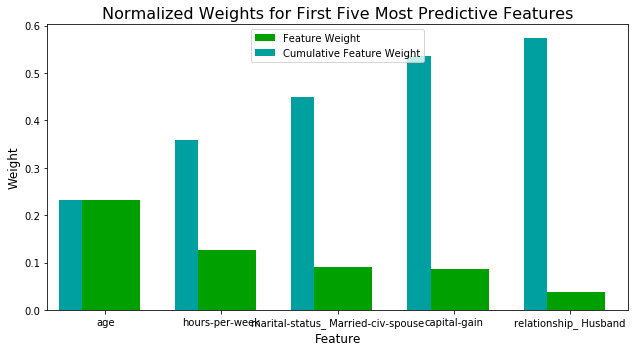

In [14]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
# TODO: Train the supervised model on the training set 
model = ExtraTreesClassifier()
model.fit(X_train, y_train)

# TODO: Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:**
The Feature Weight indicates the my thinking process for first two variables(Age, Hours-per-week) was correct. The variable I did not consider was Relationship and in that the class Husband has been selected by the model. Which means Married Men are likely to earn >=50K and is the feature with 5th in importance selected by this model. 

The Extra Tree Classifier algorithm has given more importance to Marital-status and ignored Education-num amongst top 5 probably because Education number of years was lowest in distance correlation to income at 0.667200120824. The comparision between a categorical variable marital-status and a numerical variable Education-num has been done by the algorithm correctly.

Prominently the age feature has more weight at greater than 20% rest are around the 10% mark.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [15]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

[LibSVM]Final Model trained on full data
------
Accuracy on testing data: 0.8474
F-score on testing data: 0.6996

Final Model trained on reduced data
------
Accuracy on testing data: 0.7966
F-score on testing data: 0.5146


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:**

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model | Reduced Features |
| :------------: | :-----------------: | :---------------: | :-------------: | :--------------: | 
| Accuracy Score |      0.4651         |      0.8301       |     0.8474      |    0.7966        |
| F-score        |      0.3589         |      0.6592       |     0.6996      |    0.5146        |

Reducing the number of Features has really reduced the accuracy and f-score of the model. This is below the Unoptimized model but better than the Benchmark predictor. So I will go with the Full featured Optimized model since this has the best Accuracy and F-score in this scenario.

Although training time with SVM is a big consideration. However with experimentation I have found out that the larger ranges that you give for the hyper=parameters for the algorithm such as 'C' and Gamma like if you want to test from a range of 1 to 1000 it may take even days to return the results however short ranges like 1 to 10 give results in couple of hours. So parallel testing of these ranges say in ranges of 10 like 1 to 10 and 40 to 50 could help speed up the optimization process.

Another way is to try reduce the dataset but we see that on reducing the dataset features to 5 gets us only 50% coverage. So selecting between 6-10 important features could give us higher coverage and thereby having an accuracy score above 80%. I think this would be a good tradeoff between training time and accuracy score, coverage.


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.